In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
import graphviz


# Carregar o dataset
data = pd.read_csv('Data/Google-Playstore.csv',nrows=8000) #data é um DataFrame

#remover da data as seguintes colunas:  App Name, App Id, Minimum Installs, Maximum Installs, Currency,Developer Id, Developer Website, Developer Email, Released, Last Updated, Privacy Policy, Scraped Time,

data = data.drop(['App Name', 'App Id', 'Minimum Installs', 'Maximum Installs', 'Currency','Developer Id','Developer Website', 'Developer Email', 'Released', 'Last Updated', 'Privacy Policy', 'Scraped Time'], axis=1)

# Limitar o dataset a 500.000 linhas
#data = data.head(5000) #data = data.sample(n=500000, random_state=42) #para uma amostra aleatória #se for para as PRIMEIRAS 500 000 linhas: data = data.head(500000)


# Inspecionar os primeiros registros e verificar valores ausentes
print("Dados iniciais:")
print(data.head())
print(data.info())
print("Valores ausentes antes da imputação:")
print(data.isnull().sum())

# Remover linhas onde a variável alvo 'Installs' é nula
data = data.dropna(subset=['Installs'])

# Converter a coluna 'Installs' para um formato numérico (caso seja necessária)
#data['Installs'] = pd.to_numeric(data['Installs'], errors='coerce')
# data = data.dropna(subset=['Installs'])

# Ver alguns exemplos dos valores na coluna 'Installs' antes da conversão
print("Exemplos de valores na coluna 'Installs' antes da conversão:")
print(data['Installs'].head(10))



# Vamos tratar os dados de 'Installs' para que possamos utilizá-los como variável alvo
# Remover caracteres especiais
data['Installs'] = data['Installs'].str.replace('[+,]', '', regex=True) #retira os caracteres + e , e substitui por '', ou seja, retira

# Verificar se a conversão foi bem sucedida e converter para int
data['Installs'] = pd.to_numeric(data['Installs'], errors='coerce').astype('Int64')

# Verificar novamente alguns exemplos após a conversão
print("Exemplos de valores na coluna 'Installs' após a conversão:")
print(data['Installs'].head(10))

# Atualizar os valores ausentes após a remoção de linhas
print("Valores ausentes após remoção de linhas com 'Installs' nulos:")
print(data.isnull().sum())

def handle_missing_values(df):
    # Category: Preencher com a categoria mais comum (moda)
    df['Category'].fillna(df['Category'].mode()[0], inplace=True)
    
    # Rating: Preencher com a média
    df['Rating'].fillna(df['Rating'].mean(), inplace=True)
    
    # Rating Count: Preencher com a média
    df['Rating Count'].fillna(df['Rating Count'].mean(), inplace=True)
    
    # Free: Preencher com False (assumir que não é gratuito se não informado)
    df['Free'].fillna(True, inplace=True)
    
    # Price: Preencher com 0.0 (assumir que é gratuito se não informado)
    df['Price'].fillna(0.0, inplace=True)
    
    # Size: Preencher com a média após converter para MB
    df['Size'] = df['Size'].apply(size_to_mb)
    df['Size'].fillna(df['Size'].mean(), inplace=True)
    
    # Minimum Android: Preencher com a versão mais comum (moda)
    df['Minimum Android'].fillna(df['Minimum Android'].mode()[0], inplace=True)
    
    # Content Rating: Preencher com a classificação mais comum (moda)
    df['Content Rating'].fillna(df['Content Rating'].mode()[0], inplace=True)
    
    # Ad Supported: Preencher com False (assumir que não é suportado por anúncios se não informado)
    df['Ad Supported'].fillna(True, inplace=True)
    
    # In App Purchases: Preencher com False (assumir que não tem compras no aplicativo se não informado)
    df['In App Purchases'].fillna(False, inplace=True)
    
    # Editors Choice: Preencher com False (assumir que não é escolha do editor se não informado)
    df['Editors Choice'].fillna(False, inplace=True)

def size_to_mb(size):
    # Verifica se o valor já é NaN (float)
    if pd.isna(size):
        return np.nan
    # Garante que a operação só será feita em strings
    if isinstance(size, str):
        if 'M' in size or 'm' in size:
            return float(size.replace('M', '').replace('m', '').replace(',', '.'))
        elif 'K' in size or 'k' in size:
            return float(size.replace('K', '').replace('k', '').replace(',', '.')) / 1024
        elif 'G' in size or 'g' in size:
            return float(size.replace('G', '').replace('g', '').replace(',', '.')) * 1024
    # Retorna np.nan para valores que não correspondem aos formatos esperados
    return np.nan

def parse_android_version(version):
    # Verifica se o valor é NaN
    if pd.isna(version):
        return np.nan
    # Trata o caso de 'Varies with device' substituindo por NaN
    if 'Varies with device' in version:
        return np.nan  # Ou substitua por uma média ou valor específico
    # Remove a parte 'and up' se presente
    if 'and up' in version:
        version = version.replace('and up', '').strip()
    # Se houver um intervalo de versões, pega a primeira versão do intervalo
    if '-' in version:
        version = version.split('-')[0].strip()
    # Remove o caractere 'W' se presente
    version = version.replace('W', '').strip()
    try:
        # Tenta converter a versão para float
        return float(version)
    except ValueError:
        # Se houver um erro na conversão, retorna NaN
        return np.nan


handle_missing_values(data)

# Aplicando a conversão atualizada e criando o histograma
#data['Size'] = data['Size'].apply(size_to_mb)

# Aplica a função parse_android_version para cada valor na coluna 'Minimum Android'
data['Minimum Android'] = data['Minimum Android'].apply(parse_android_version)

# Calcula a média das versões numéricas do Android
mean_android_version = data['Minimum Android'].mean()

# Preenche os valores NaN com a média calculada
data['Minimum Android'].fillna(mean_android_version, inplace=True)

data['Rating Count'] = data['Rating Count'].astype(int)
data['Minimum Android'] = [int(x * 10) / 10 for x in data['Minimum Android']]

label_encoder = LabelEncoder()

data['Category'] = label_encoder.fit_transform(data['Category'])
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
data['Content Rating'] = label_encoder.fit_transform(data['Content Rating'])
content_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


print("Content Mapping ", content_mapping, "\nCategory Mapping ", category_mapping)

# Preparação dos dados
# Suponha que a coluna 'Installs' é a variável alvo e as outras são features
X = data[['Category', 'Rating','Rating Count', 'Free','Price','Size','Minimum Android','Content Rating', 'Ad Supported','In App Purchases','Editors Choice']]
y = data['Installs']

# Função para calcular os valores desejados para cada coluna
def column_statistics(column):
    unique_values = data[column].dropna().unique()
    mean_value = data[column].mean() if pd.api.types.is_numeric_dtype(data[column]) else None
    max_value = data[column].max() if pd.api.types.is_numeric_dtype(data[column]) else None
    min_value = data[column].min() if pd.api.types.is_numeric_dtype(data[column]) else None
    null_count = data[column].isnull().sum()
    
    return {
        'Unique Values': unique_values,
        'Mean': mean_value,
        'Max': max_value,
        'Min': min_value,
        'Null Count': null_count
    }

# Aplicar a função para cada coluna desejada
columns = ['Category', 'Rating', 'Rating Count', 'Free', 'Price', 'Size', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Editors Choice']
stats = {column: column_statistics(column) for column in columns}

stats_df = pd.DataFrame(stats).transpose()

stats_df

Dados iniciais:
        Category  Rating  Rating Count Installs  Free  Price  Size  \
0      Adventure     0.0           0.0      10+  True    0.0   10M   
1          Tools     4.4          64.0   5,000+  True    0.0  2.9M   
2   Productivity     0.0           0.0      50+  True    0.0  3.7M   
3  Communication     5.0           5.0      10+  True    0.0  1.8M   
4          Tools     0.0           0.0     100+  True    0.0  6.2M   

  Minimum Android Content Rating  Ad Supported  In App Purchases  \
0      7.1 and up       Everyone         False             False   
1      5.0 and up       Everyone          True             False   
2    4.0.3 and up       Everyone         False             False   
3    4.0.3 and up       Everyone          True             False   
4      4.1 and up       Everyone         False             False   

   Editors Choice  
0           False  
1           False  
2           False  
3           False  
4           False  
<class 'pandas.core.frame.DataFram

,Unique Values,Mean,Max,Min,Null Count
Category,"[1, 42, 33, 13, 39, 23, 24, 31, 35, 25, 43, 20...",23.03988,47,0,0
Rating,"[0.0, 4.4, 5.0, 4.5, 2.0, 4.7, 4.9, 3.9, 3.7, ...",2.195801,5.0,0.0,0
Rating Count,"[0, 64, 5, 12, 39, 820, 55, 118, 1572, 16, 6, ...",1578.567946,1264773,0,0
Free,"[True, False]",0.979622,True,False,0
Price,"[0.0, 1.99, 4.99, 0.99, 2.99, 3.49, 24.99, 4.4...",0.10787,99.99,0.0,0
Size,"[10.0, 2.9, 3.7, 1.8, 6.2, 46.0, 2.5, 16.0, 1....",18.816538,531.0,0.000983,0
Minimum Android,"[7.1, 5.0, 4.3, 4.1, 6.0, 4.4, 4.0, 4.2, 2.1, ...",4.367071,8.0,1.0,0
Content Rating,"[0, 3, 2, 1]",0.311539,3,0,0
Ad Supported,"[False, True]",0.484061,True,False,0
In App Purchases,"[False, True]",0.07651,True,False,0


In [2]:


# Verificar se ainda existem valores ausentes em y
#print(f"Valores ausentes em y: {y.isnull().sum()}")


# Identificar variáveis numéricas e categóricas
#numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
#categorical_features = X.select_dtypes(include=['object']).columns

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Função para avaliar o modelo e retornar o pipeline treinado
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Verificar o tipo de 'y' antes do treinamento
    print(f"Tipo de 'y' (Installs) antes do treino: {y_train.dtype}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Model: {name}")
    print(f"R^2: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}\n")
    return model
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tamanho atual do dataframe: (7999, 12)


In [3]:
#Saber informações sobre o dataframe
print("data.info():", data.info())
#Ter o describe do dataset
print("data.describe():", data.describe())
#Qual o tipo de dados da coluna 'Installs'
print("Tipo de dados da coluna 'Installs':", data['Installs'].dtype)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 7999 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          7999 non-null   int32  
 1   Rating            7999 non-null   float64
 2   Rating Count      7999 non-null   int32  
 3   Installs          7999 non-null   Int64  
 4   Free              7999 non-null   bool   
 5   Price             7999 non-null   float64
 6   Size              7999 non-null   float64
 7   Minimum Android   7999 non-null   float64
 8   Content Rating    7999 non-null   int32  
 9   Ad Supported      7999 non-null   bool   
 10  In App Purchases  7999 non-null   bool   
 11  Editors Choice    7999 non-null   bool   
dtypes: Int64(1), bool(4), float64(4), int32(3)
memory usage: 507.7 KB
data.info(): None
data.describe():           Category       Rating  Rating Count        Installs        Price  \
count  7999.000000  7999.000000  7.999000e+03          7

In [4]:
# Avaliar modelo e obter o pipeline treinado
evaluate_model('Linear Regression', LinearRegression(), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

print("Tamanho atual do dataframe 2:", data.shape)
#Saber informações sobre o dataframe
print("data.info():", data.info())
#Ter o describe do dataset
print("data.describe():", data.describe())
#Qual o tipo de dados da coluna 'Installs'
print("Tipo de dados da coluna 'Installs':", data['Installs'].dtype)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)


Tipo de 'y' (Installs) antes do treino: Int64
Model: Linear Regression
R^2: 0.7605
MAE: 122656.3307
MSE: 1608324472393.4890
RMSE: 1268197.3318

Tamanho atual do dataframe: (7999, 12)
Tamanho atual do dataframe 2: (7999, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 7999 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          7999 non-null   int32  
 1   Rating            7999 non-null   float64
 2   Rating Count      7999 non-null   int32  
 3   Installs          7999 non-null   Int64  
 4   Free              7999 non-null   bool   
 5   Price             7999 non-null   float64
 6   Size              7999 non-null   float64
 7   Minimum Android   7999 non-null   float64
 8   Content Rating    7999 non-null   int32  
 9   Ad Supported      7999 non-null   bool   
 10  In App Purchases  7999 non-null   bool   
 11  Editors Choice    7999 non-null   bool   
dtypes: Int64(1)

In [5]:
'''
# Carregar o ficheiro CSV da nova app
new_app_df = pd.read_csv('new_app.csv')  # Substitua 'path/to/' pelo caminho correto do seu ficheiro CSV

# Remover colunas não presentes nos dados de treino
new_app_df = new_app_df[X.columns]

# Função para prever a variável alvo para uma nova app
def predict_new_app(pipeline, new_app):
    # Preprocessar a nova app
    new_app_transformed = pipeline.named_steps['preprocessor'].transform(new_app)
    # Prever a variável alvo
    prediction = pipeline.named_steps['model'].predict(new_app_transformed)
    return prediction

# Fazer a previsão utilizando o pipeline treinado anteriormente
prediction = predict_new_app(pipeline, new_app_df)
print(f"Previsão de 'Installs' para a nova app 'Gakondo': {prediction[0]:.0f}")
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)
'''

'\n# Carregar o ficheiro CSV da nova app\nnew_app_df = pd.read_csv(\'new_app.csv\')  # Substitua \'path/to/\' pelo caminho correto do seu ficheiro CSV\n\n# Remover colunas não presentes nos dados de treino\nnew_app_df = new_app_df[X.columns]\n\n# Função para prever a variável alvo para uma nova app\ndef predict_new_app(pipeline, new_app):\n    # Preprocessar a nova app\n    new_app_transformed = pipeline.named_steps[\'preprocessor\'].transform(new_app)\n    # Prever a variável alvo\n    prediction = pipeline.named_steps[\'model\'].predict(new_app_transformed)\n    return prediction\n\n# Fazer a previsão utilizando o pipeline treinado anteriormente\nprediction = predict_new_app(pipeline, new_app_df)\nprint(f"Previsão de \'Installs\' para a nova app \'Gakondo\': {prediction[0]:.0f}")\n#Imprimir tamanho do dataframe\nprint("Tamanho atual do dataframe:", data.shape)\n'

In [6]:
# Avaliar modelo
evaluate_model('Ridge Regression', Ridge(alpha=1.0), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tipo de 'y' (Installs) antes do treino: Int64
Model: Ridge Regression
R^2: 0.7604
MAE: 122947.1963
MSE: 1608926612438.5813
RMSE: 1268434.7096

Tamanho atual do dataframe: (7999, 12)


In [7]:
# Avaliar modelo
evaluate_model('Ridge Regression', Ridge(alpha=1.0), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tipo de 'y' (Installs) antes do treino: Int64
Model: Ridge Regression
R^2: 0.7604
MAE: 122947.1963
MSE: 1608926612438.5813
RMSE: 1268434.7096

Tamanho atual do dataframe: (7999, 12)


In [8]:

# Avaliar modelo
evaluate_model('Lasso Regression', Lasso(alpha=1.0), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)


Tipo de 'y' (Installs) antes do treino: Int64
Model: Lasso Regression
R^2: 0.7605
MAE: 122655.1847
MSE: 1608326282876.2549
RMSE: 1268198.0456

Tamanho atual do dataframe: (7999, 12)


In [9]:
# Avaliar modelo
evaluate_model('Logistic Regression', LogisticRegression(), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tipo de 'y' (Installs) antes do treino: Int64
Model: Logistic Regression
R^2: 0.1945
MAE: 122165.9475
MSE: 5409549306374.1836
RMSE: 2325843.7837

Tamanho atual do dataframe: (7999, 12)


C:\Users\Ivani\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# Avaliar modelo
evaluate_model('SVR (linear kernel)', SVR(kernel='linear'), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tipo de 'y' (Installs) antes do treino: Int64
Model: SVR (linear kernel)
R^2: 0.6397
MAE: 100374.2236
MSE: 2419726810769.4692
RMSE: 1555547.1098

Tamanho atual do dataframe: (7999, 12)


In [11]:
# Avaliar modelo
evaluate_model('SVR (rbf kernel)', SVR(kernel='rbf'), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tipo de 'y' (Installs) antes do treino: Int64
Model: SVR (rbf kernel)
R^2: -0.0032
MAE: 146634.7710
MSE: 6736969995509.6279
RMSE: 2595567.3745

Tamanho atual do dataframe: (7999, 12)


In [12]:
# Avaliar modelo
evaluate_model('K-NN', KNeighborsRegressor(n_neighbors=2), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tipo de 'y' (Installs) antes do treino: Int64
Model: K-NN
R^2: 0.6011
MAE: 112057.1084
MSE: 2678711175340.8379
RMSE: 1636676.8696

Tamanho atual do dataframe: (7999, 12)


In [13]:
# Avaliar modelo
model_tree = evaluate_model('Decision Tree', DecisionTreeRegressor(), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)


Tipo de 'y' (Installs) antes do treino: Int64
Model: Decision Tree
R^2: 0.1923
MAE: 138036.7685
MSE: 5424234110858.9717
RMSE: 2328998.5210

Tamanho atual do dataframe: (7999, 12)


In [14]:
# Avaliar modelo
evaluate_model('K_Means', KMeans(n_clusters=4), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tipo de 'y' (Installs) antes do treino: Int64


C:\Users\Ivani\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model: K_Means
R^2: -0.0032
MAE: 146737.1681
MSE: 6737138823577.7002
RMSE: 2595599.8967

Tamanho atual do dataframe: (7999, 12)


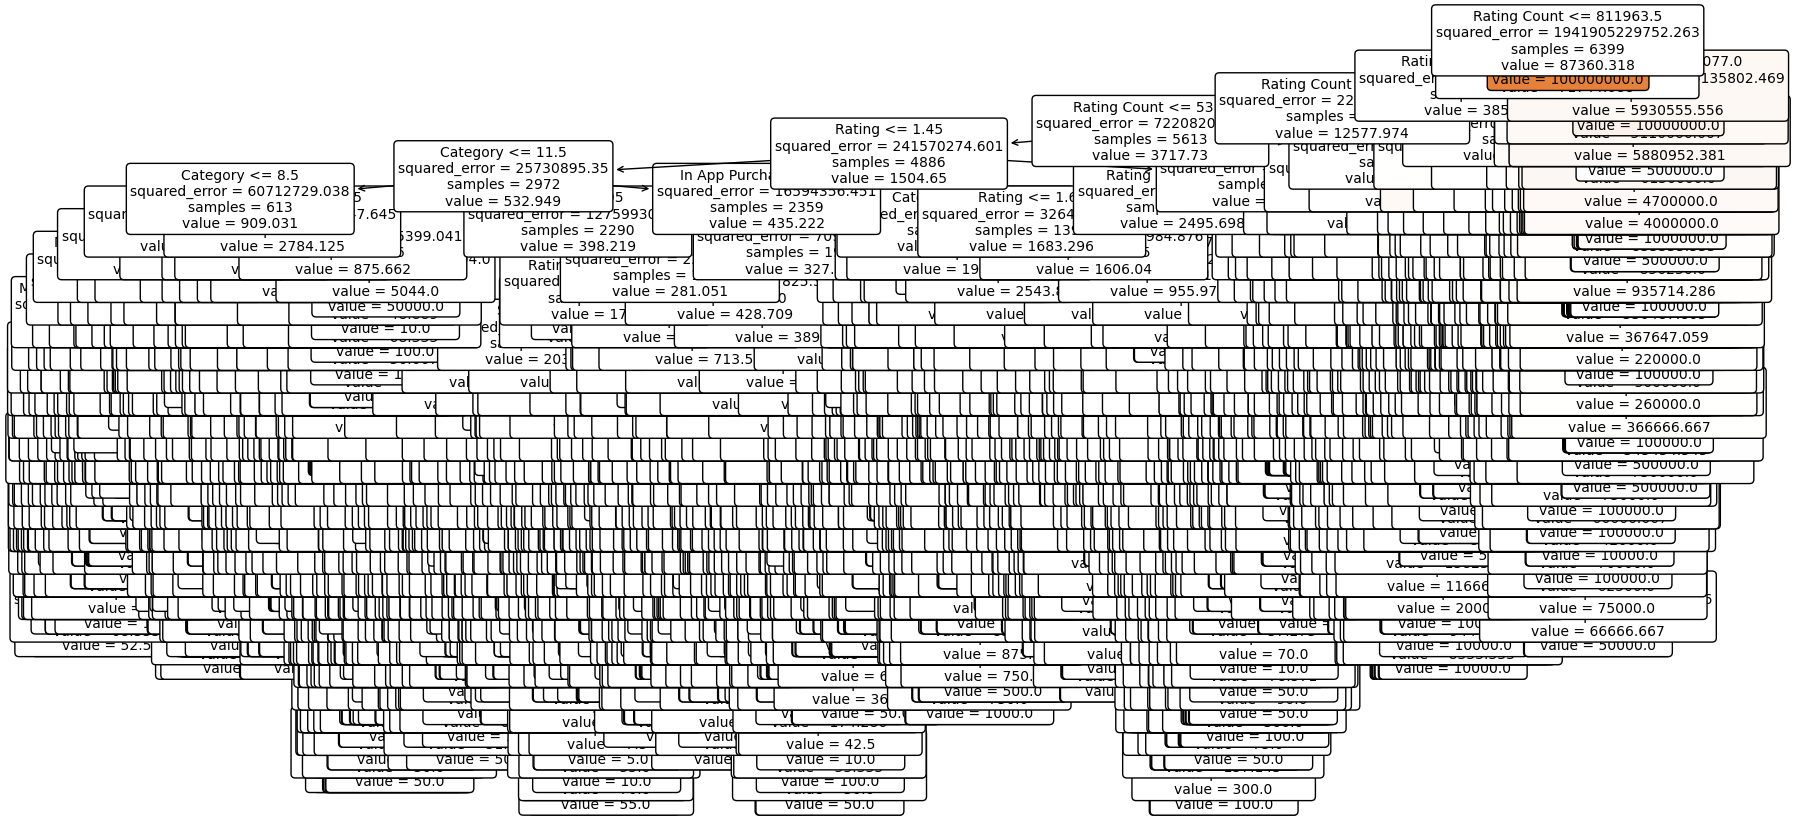

In [15]:

# Visualizar a árvore de decisão
plt.figure(figsize=(20,10))
plot_tree(model_tree, filled=True, feature_names=X.columns, rounded=True, fontsize=10)
plt.show()



In [16]:
# Avaliar modelo
model_random = evaluate_model('Random Forest', RandomForestRegressor(n_estimators= 200), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tipo de 'y' (Installs) antes do treino: Int64
Model: Random Forest
R^2: 0.5559
MAE: 116824.3713
MSE: 2982572321399.2402
RMSE: 1727012.5423

Tamanho atual do dataframe: (7999, 12)


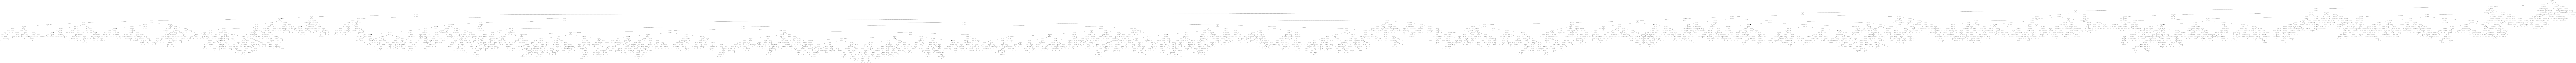

In [23]:
import os

# Visualizar uma árvore do Random Forest
estimator = model_random.estimators_[0]

# Exportar a árvore para o formato Graphviz
export_graphviz(estimator, out_file='tree.dot', feature_names=X.columns, rounded=True, precision=1)

# Converter o arquivo .dot para PNG
os.system('dot -Tpng tree.dot -o tree.png')

# Visualizar a imagem
from IPython.display import Image
Image(filename='tree.png')

In [18]:
'''
# Extrair o modelo Random Forest treinado do pipeline
random_forest_model = pipeline.named_steps['model']

# Selecionar uma árvore do Random Forest
estimator = random_forest_model.estimators_[0]

# Plotar a árvore do Random Forest
plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("Uma Árvore do Random Forest")
plt.show()'''

'\n# Extrair o modelo Random Forest treinado do pipeline\nrandom_forest_model = pipeline.named_steps[\'model\']\n\n# Selecionar uma árvore do Random Forest\nestimator = random_forest_model.estimators_[0]\n\n# Plotar a árvore do Random Forest\nplt.figure(figsize=(20, 10))\nplot_tree(estimator, feature_names=X.columns, filled=True, rounded=True, fontsize=10)\nplt.title("Uma Árvore do Random Forest")\nplt.show()'

In [19]:
# Avaliar modelo 
evaluate_model('Neural Network (single layer)', MLPRegressor(hidden_layer_sizes=(10000,), max_iter=10000), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tipo de 'y' (Installs) antes do treino: Int64
Model: Neural Network (single layer)
R^2: 0.7598
MAE: 96068.1851
MSE: 1613239948810.3269
RMSE: 1270133.8311

Tamanho atual do dataframe: (7999, 12)


In [20]:
# Avaliar modelo
evaluate_model('Neural Network (multi layer)', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000), X_train, y_train, X_test, y_test)
#Imprimir tamanho do dataframe
print("Tamanho atual do dataframe:", data.shape)

Tipo de 'y' (Installs) antes do treino: Int64
Model: Neural Network (multi layer)
R^2: 0.7594
MAE: 96157.6520
MSE: 1615897092302.4099
RMSE: 1271179.4100

Tamanho atual do dataframe: (7999, 12)
